In [9]:
# --- 0. 安装必要的库 ---
# LDA和Coherence需要 'gensim' 库
# 确保您的Kaggle Notebook已在 "Settings" -> "Internet" 中开启网络
!pip install -q gensim

# --- 1. 导入库 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import sys
import re

# 导入 gensim
try:
    from gensim.corpora import Dictionary
    from gensim.models import LdaModel, CoherenceModel
except ImportError:
    print("错误：无法导入 gensim。")
    print("请确保Kaggle Notebook已开启网络，并已成功运行 !pip install gensim。")
    sys.exit()

# --- 2. 设置字体和文件路径 (Kaggle路径) ---
# 按照您的要求，设置Kaggle输入目录
input_dir = '/kaggle/input/nssfc-2025/'

font_path_chinese = os.path.join(input_dir, 'simkai.ttf')
font_path_english = os.path.join(input_dir, 'times.ttf')
data_file = os.path.join(input_dir, 'nssfc-fenci.csv')

# 检查字体文件
if not os.path.exists(font_path_chinese):
    print(f"警告: 字体文件 '{font_path_chinese}' 未找到。中文可能无法正确显示。")
    ch_font = fm.FontProperties()
else:
    ch_font = fm.FontProperties(fname=font_path_chinese)
    fm.fontManager.addfont(font_path_chinese)

if not os.path.exists(font_path_english):
    print(f"警告: 字体文件 '{font_path_english}' 未找到。非中文字符可能无法使用指定字体。")
    en_font = fm.FontProperties()
else:
    en_font = fm.FontProperties(fname=font_path_english)
    fm.fontManager.addfont(font_path_english)

# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False 

# --- 3. 加载和准备数据 ---
print(f"正在从 '{data_file}' 加载数据...")
try:
    df = pd.read_csv(data_file)
except FileNotFoundError:
    print(f"错误: 数据文件 '{data_file}' 未找到。")
    print("请确保您的数据文件和字体文件已上传到Kaggle的 '/kaggle/input/nssfc-2025/' 数据集中。")
    sys.exit()

print("数据加载成功。")

正在从 '/kaggle/input/nssfc-2025/nssfc-fenci.csv' 加载数据...
数据加载成功。


正在准备 '管理学' 文本数据...
共找到 590 篇 '管理学' 文档。
正在准备 '管理学' 文本数据...
将从文本中移除 61 个自定义停用词...
停用词移除完成。
正在创建 Gensim 词典和语料库...
词典和语料库创建完成。词典大小 (过滤后): 543
开始 LDA 评估循环 (K=2 到 20)...
  正在计算 K=2...
    K=2: Perplexity=61.781, C_v Coherence=0.360
  正在计算 K=3...
    K=3: Perplexity=66.553, C_v Coherence=0.342
  正在计算 K=4...
    K=4: Perplexity=70.366, C_v Coherence=0.415
  正在计算 K=5...
    K=5: Perplexity=73.578, C_v Coherence=0.390
  正在计算 K=6...
    K=6: Perplexity=73.619, C_v Coherence=0.433
  正在计算 K=7...
    K=7: Perplexity=74.802, C_v Coherence=0.435
  正在计算 K=8...
    K=8: Perplexity=78.297, C_v Coherence=0.462
  正在计算 K=9...
    K=9: Perplexity=78.558, C_v Coherence=0.477
  正在计算 K=10...
    K=10: Perplexity=79.928, C_v Coherence=0.504
  正在计算 K=11...
    K=11: Perplexity=81.370, C_v Coherence=0.496
  正在计算 K=12...
    K=12: Perplexity=83.365, C_v Coherence=0.513
  正在计算 K=13...
    K=13: Perplexity=82.491, C_v Coherence=0.503
  正在计算 K=14...
    K=14: Perplexity=91.585, C_v Coherence=0.529
  正在计算 K=15...
    K

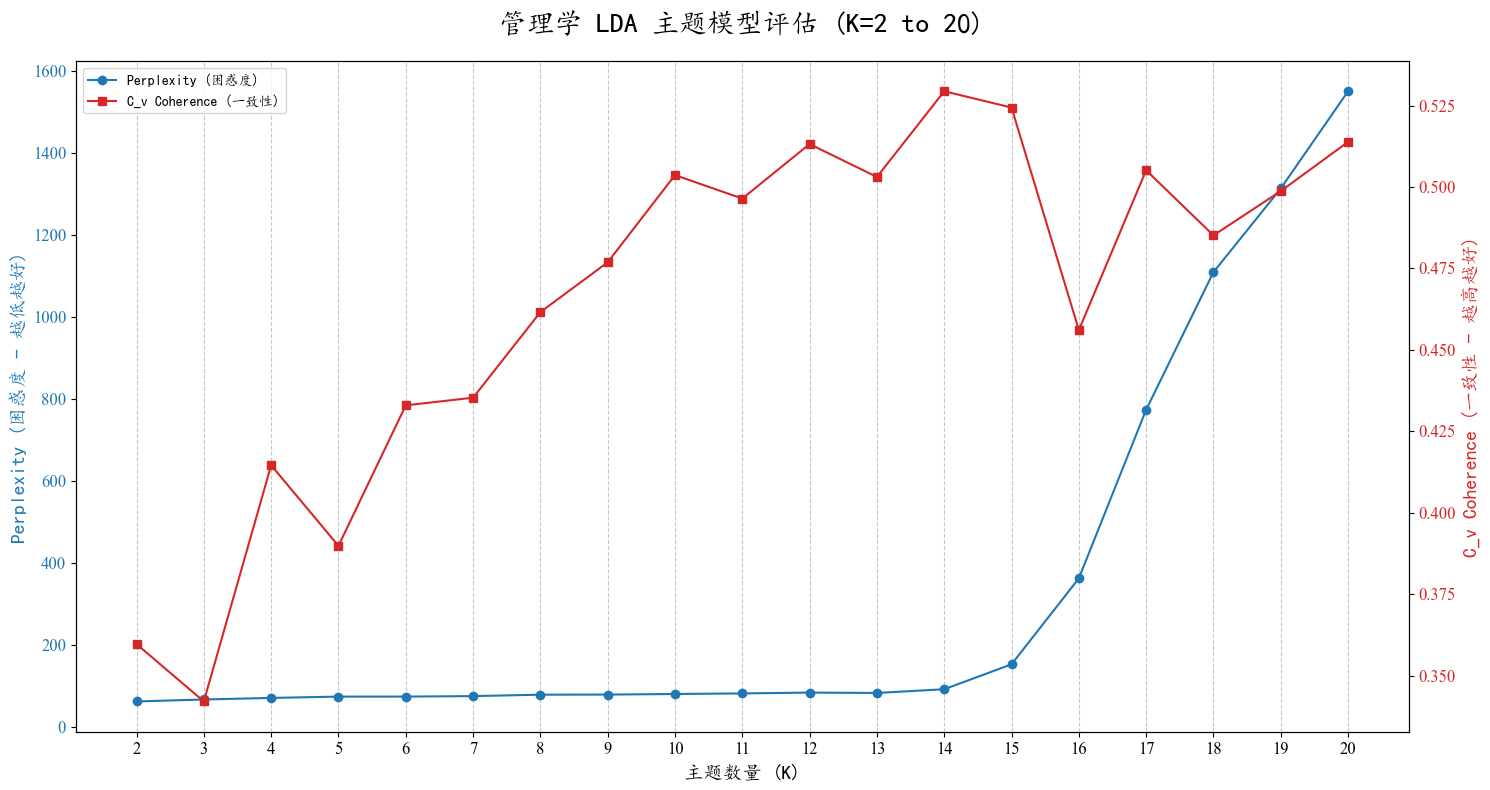

所有任务完成。


In [10]:
# 筛选 '管理学'
target_discipline = '管理学'
management_df = df[df['涉及学科'] == target_discipline].copy()

if management_df.empty:
    print(f"错误：未能在数据中找到学科门类 '{target_discipline}'。")
    sys.exit()

# 准备文本数据：'{项目名称分词}' 是一个字符串，需要按空格分割
print("正在准备 '管理学' 文本数据...")
# 确保数据是字符串类型并分割
texts = management_df['课题名称分词'].dropna().apply(lambda x: str(x).split()).tolist()

if not texts:
    print("错误：'管理学' 分词数据为空。")
    sys.exit()
    
print(f"共找到 {len(texts)} 篇 '管理学' 文档。")

# --- 4. 文本预处理 (新增：移除停用词) ---
print("正在准备 '管理学' 文本数据...")
# 1. 加载原始分词文本
texts_raw = management_df['课题名称分词'].dropna().apply(lambda x: str(x).split()).tolist()

# 2. 定义常见的项目名称停用词 (您可以根据需要增删)
# 1. 研究元词汇与方法论相关
research_meta_stopwords = [
    '影响', '体系', '视域', '机理', '效应', '构建', '建构', '理论', '实践', 
    '对策', '视角', '背景', '基于', '模式', '应用', '问题', '评估', '测度', 
    '关系', '形成', '重构', '逻辑', '形态', '系统', '模型', '演化', '演变', 
    '经验', '资料', '史料', '要素', '研究', '机制', '路径', '及其'
]

# 2. 高度泛化的背景词
generalized_context_stopwords = [
    '中国', '社会', '我国', '国家', '时代', '当代', '时期', '历史', 
    '世纪', '1949', '近代'
]

# 3. 抽象的过程、目标与修饰词
abstract_process_stopwords = [
    '策略', '提升', '优化', '整理', '驱动', '赋能', '建设', '实现', '应对', 
    '促进', '困境', '动态', '识别', '效能', '交融'
]

# 合并所有停用词
my_stop_words  = research_meta_stopwords+generalized_context_stopwords+abstract_process_stopwords
print(f"将从文本中移除 {len(my_stop_words)} 个自定义停用词...")

# 3. 从 texts 中移除停用词
texts_processed = [
    [word for word in doc if word not in my_stop_words]
    for doc in texts_raw
]

if not texts_processed:
    print("错误：移除停用词后所有文档均为空。")
    sys.exit()

print("停用词移除完成。")

# --- 创建 Gensim 词典和语料库 (使用处理后的文本) ---
print("正在创建 Gensim 词典和语料库...")
# 使用处理过的文本 (texts_processed) 创建词典
id2word = Dictionary(texts_processed)

# 过滤词典：
# no_below=2: 移除那些在总共不到2个文档中出现过的词
# no_above=0.5: 移除那些在超过50%的文档中都出现过的词 (高频词)
id2word.filter_extremes(no_below=2, no_above=0.5)

# 使用处理过的文本和过滤后的词典创建语料库 (BoW)
corpus = [id2word.doc2bow(text) for text in texts_processed]

# 检查语料库是否为空
if not any(corpus):
    print("错误：语料库为空，可能是过滤条件过于严格。")
    sys.exit()

print(f"词典和语料库创建完成。词典大小 (过滤后): {len(id2word)}")

# --- 5. LDA 主题模型评估循环 ---
# K∈[2,20]
K_range = range(2, 21)
perplexity_scores = []
coherence_scores_cv = []

print(f"开始 LDA 评估循环 (K=2 到 {max(K_range)})...")

for k in K_range:
    print(f"  正在计算 K={k}...")
    # 训练LDA模型
    lda_model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=k,
        random_state=2025, # 保证结果可复现
        passes=10,      # 增加训练遍数以提高稳定性
        chunksize=100
    )
    
    # a. 计算 Perplexity (困惑度)
    # log_perplexity 返回的是每个词的平均对数似然
    # Perplexity = 2^(-log_perplexity)
    log_perplexity = lda_model.log_perplexity(corpus)
    perplexity = np.exp2(-log_perplexity)
    perplexity_scores.append(perplexity)
    
    # b. 计算 C_v Coherence (一致性)
    coherence_model_cv = CoherenceModel(
        model=lda_model,
        texts=texts, # C_v 需要原始文本
        dictionary=id2word,
        coherence='c_v'
    )
    coherence_cv = coherence_model_cv.get_coherence()
    coherence_scores_cv.append(coherence_cv)
    
    print(f"    K={k}: Perplexity={perplexity:.3f}, C_v Coherence={coherence_cv:.3f}")

print("LDA 评估循环完成。")

# --- 6. 绘制评估指标图表 ---
print("正在生成评估图表...")
fig, ax1 = plt.subplots(figsize=(15, 8))

# 标题
plt.title(f'{target_discipline} LDA 主题模型评估 (K=2 to 20)', fontproperties=ch_font, fontsize=20, pad=20)

# X轴
ax1.set_xlabel('主题数量 (K)', fontproperties=ch_font, fontsize=14)
ax1.set_xticks(list(K_range)) # 确保X轴刻度为整数
plt.setp(ax1.get_xticklabels(), fontproperties=en_font, fontsize=12)

# Y轴1 (Perplexity - 越低越好)
color1 = 'tab:blue'
ax1.set_ylabel('Perplexity (困惑度 - 越低越好)', fontproperties=ch_font, fontsize=14, color=color1)
line1 = ax1.plot(K_range, perplexity_scores, 'o-', color=color1, label='Perplexity (困惑度)')
ax1.tick_params(axis='y', labelcolor=color1)
plt.setp(ax1.get_yticklabels(), fontproperties=en_font, fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7, axis='x')

# Y轴2 (Coherence - 越高越好)
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('C_v Coherence (一致性 - 越高越好)', fontproperties=ch_font, fontsize=14, color=color2)
line2 = ax2.plot(K_range, coherence_scores_cv, 's-', color=color2, label='C_v Coherence (一致性)')
ax2.tick_params(axis='y', labelcolor=color2)
plt.setp(ax2.get_yticklabels(), fontproperties=en_font, fontsize=12)

# 合并图例
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best', prop=ch_font, fontsize=12)

fig.tight_layout() # 调整布局以防止重叠

# --- 7. 显示和保存图表 ---
# 在Kaggle中，输出文件保存在 '/kaggle/working/' 目录
output_filename = 'management_lda_metrics.png'

# ✅ 若前面未显式创建 fig，可获取当前 Figure
fig = plt.gcf()

# ✅ 先保存，再显示
try:
    fig.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"图表已成功保存为: {output_filename} (位于 /kaggle/working/ 目录)")
except Exception as e:
    print(f"保存图表 '{output_filename}' 时出错: {e}")

# ✅ 然后再显示（不会影响已保存内容）
try:
    print(f"正在显示图表: {target_discipline} LDA 评估")
    plt.show()
except Exception as e:
    print(f"显示图表时出错: {e}")

# ✅ 最后关闭图形，释放内存
plt.close(fig)
print("所有任务完成。")


In [11]:
print("K=14")

K=14
